In [228]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import *
import os

# resource: https://astrogeology.usgs.gov/search/map/Moon/LMMP/Apollo15/LRO_NAC_DEM_Apollo_15_26N004E_150cmp
# Height (Elevation m) = DN; Planetary Radius = DN + 1737400m
Image.MAX_IMAGE_PIXELS = None
dem_path = '../dataset/LRO_NAC_DEM_Apollo_15_26N004E_150cmp.tif'


img = Image.open(dem_path)
img = np.asarray(img, dtype=np.float16)
width,height = img.shape[0],img.shape[1]
mid_x,mid_y = int(width/2)-1700,int(height/2)-1500
crop_height, crop_width = 200,200
img = img[mid_x:mid_x+crop_width,mid_y:mid_y+crop_height]
img = img - np.mean(img)

out_path='../dataset/Small_map'

In [261]:
def save_dem(img, out_path='../dataset', name='dem.npy'):
    out_name = os.path.join(out_path, name)
    with open(out_name, 'wb') as f:
        np.save(f, img)
    return out_name

def open_dem(dem_path):
    with open(dem_path, 'rb') as f:
        dem = np.load(f)
    return dem

In [230]:
#from matplotlib.mlab import griddata

def plot_mesh(img, export_img=False, out_path='../dataset'):
    xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
    yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
    z = img.flatten() # Height in meters
    Z = img
    X, Y = np.meshgrid(xi, yi)

    fig = plt.figure(figsize=(20,16))
    ax = Axes3D(fig)
  #  ax.scatter3D(X,Y,z,c=z,cmap=plt.cm.jet)  

    my_cmap = plt.cm.RdYlGn_r
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=my_cmap,
                       linewidth=0, antialiased=True)
    fig.colorbar(surf, ax = ax,
             shrink = 0.3,
             aspect = 10,
             format="%.1f m")
    
    cset = ax.contourf(X, Y, Z,
                   zdir ='z',
                   offset = -20,
                   cmap = 'Greys_r')
    fig.suptitle('LRO NAC DEM Apollo 15 26N004E  \n ---------------------------------------------------------------\n Obszar: X [{}:{}]  | Y [{}:{}]  '.format(
        mid_x,mid_x+crop_width,mid_y,mid_y+crop_height), fontsize=20)

    ax.set_xlabel('Siatka mapy: kierunek X [m]', fontsize = 16)
    ax.set_ylabel('Siatka mapy: kierunek Y [m]', fontsize = 16)
    ax.set_zlabel('Wysokość terenu [m]', fontsize = 16)

    ax.set_zlim(-20, 20)
    if export_img:
        plot_name = os.path.join(out_path, 'DEM_plot.jpg')
        plt.savefig(plot_name)
    plt.show()
    



In [240]:
from math import sqrt, atan
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import colors

# 3D slope calculation
# https://www.youtube.com/watch?v=5gVdvxjKh4A
def calculate_slope(img, deg=True):
    slope = np.zeros_like(img)
    res = 0.5     # x,y res = 0,5 m
    for x in range(2,img.shape[0]-2):
        for y in range(2,img.shape[1]-2):
          #  mean_xp_axis = img[x+1:x+2,y].mean() 
          #  mean_xn_axis = img[x-2:x-1,y].mean()
          #  dz_dx = mean_xp_axis - mean_xn_axis/(res*2)
            
          #  mean_yp_axis = img[x,y+1:y+2].mean() 
          #  mean_yn_axis = img[x,y-2:y-1].mean()
          #  dz_dy = mean_yp_axis - mean_yn_axis/(res*2)
            dz_dx = (img[x+1,y]-img[x-1,y]) /(res*2)
            dz_dy = ((img[x,y+1]-img[x,y-1])/(res*2))
            slope[x,y]= atan(sqrt(dz_dx**2+dz_dy**2))
    if deg:
        slope = np.rad2deg(slope)
        print('Min slope: {} Median slope: {} Max slope: {}'.format(np.min(slope), np.median(slope[slope>0]), np.max(slope)))
    return slope

def safe_area(safe_slope, thresh=40):
    safe_slope[safe_slope < thresh] = 0
    safe_slope[safe_slope >= thresh] = 255
    return np.array(safe_slope,dtype=np.int8)

def plot_safe_slope(safe_slope, export_img=False, out_path='../dataset'):
    danger_color = (0.6, 0.3, 0.3, 0.6)
    safe_color = (0.1, 0.7, 0.2, 0.1)
    cmp=ListedColormap([danger_color,safe_color])
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(10,10), dpi=144)
        xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
        yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
        #Z = 
        #plt.pcolormesh(safe_slope, cmap='Greys')
        #plt.scatter(xi,yi, cmap='Greys')

        ax.imshow(safe_slope, cmap=cmp)
        fig.suptitle("Ocena możliwości trawersu", fontsize=16)
        plt.xlabel("Kierunek x [m]", fontsize=10)
        plt.ylabel("Kierunek Y [m]", fontsize=10)
        ax.invert_yaxis()

        locs_x = (np.arange(0, safe_slope.shape[0], step=20)) 
        labels_x = locs_x/2
        plt.xticks(ticks=locs_x, labels=labels_x)

        locs_y = (np.arange(0, safe_slope.shape[1], step=20)) 
        labels_y = locs_y/2
        plt.yticks(ticks=locs_y, labels=labels_y)
        

        legend_handles = [Patch(color=safe_color, label='Bezpieczny'),  
                          Patch(color=danger_color, label='Niebezpieczny')]  
        plt.legend(handles=legend_handles, ncol=2, bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=.8)
        #plt.legend()
        if export_img:
            plot_name = os.path.join(out_path, 'Safe_slope_plot.jpg')
            plt.savefig(plot_name)
        plt.show()
        
def analyze_slope_map(img, export_img=False, out_path='../dataset'):
    slope = calculate_slope(img)
    safe_slope = safe_area(slope)
    plot_safe_slope(safe_slope,export_img, out_path)

In [241]:
## PLOT MAP START AND FINISH

def plot_start_end(img,start,end, export_img=False, out_path='../dataset'):

    danger_color = (0.3, 0.3, 0.3, 0.3)
    safe_color = (0.9, 1, 0.9, 0.1)

    markers_color = (0.92, 0.7, 0, 0.8)
    
    font = {'family': "monospace",
        'color':  (0.92, 0.7, 0, 1),
        'weight': 'bold',
        'size': 10,
        }

    
    cmp=ListedColormap([danger_color,safe_color])
    with plt.style.context('ggplot'):
        fig, ax = plt.subplots(figsize=(10,10), dpi=144)
        xi = np.arange(0, img.shape[0],1) * 0.5 # Grid in meters
        yi = np.arange(0, img.shape[1],1) * 0.5 # Grid in meters
        #Z = 
        #plt.pcolormesh(safe_slope, cmap='Greys')
        #plt.scatter(xi,yi, cmap='Greys')

        ax.imshow(img, cmap=cmp)
        start_point = ax.plot(start[0], start[1], marker="H", markeredgecolor=markers_color,
                            markersize=12, markerfacecolor=markers_color, label='Punkt startowy') # Start point plot 
        ax.text(start[0]+start[0]*0.02, 
                start[1]+start[1]*0.02, r'Punkt startowy', fontdict=font) 
        end_point = ax.plot(end[0], end[1], marker="X", label='Punkt końcowy', 
                            markersize=12, markeredgecolor=markers_color,markerfacecolor=markers_color) # End point plot )
        ax.text(end[0]+end[0]*0.02, 
                end[1]+end[1]*0.02, r'Punkt końcowy', fontdict=font) 
        
        plt.title("Punkt startu i mety dla trasy", fontsize=14)
        plt.xlabel("Kierunek x [m]", fontsize=10)
        plt.ylabel("Kierunek Y [m]", fontsize=10)
        ax.invert_yaxis()

        locs_x = (np.arange(0, img.shape[0], step=20)) 
        labels_x = locs_x/2
        plt.xticks(ticks=locs_x, labels=labels_x)

        locs_y = (np.arange(0, img.shape[1], step=20)) 
        labels_y = locs_y/2
        plt.yticks(ticks=locs_y, labels=labels_y)
        

#         legend_handles = [Patch(color=markers_color, label='Punkty na trasie'),]   
#         plt.legend(handles=legend_handles, ncol=2, 
#                    bbox_to_anchor=[0.5, 1.02], loc='lower center', fontsize=8, handlelength=.8)
        #plt.legend()
        if export_img:
            plot_name = os.path.join(out_path, 'Start_end_plot.jpg')
            plt.savefig(plot_name)
        plt.show()


In [231]:
dem_name = save_dem(img, out_path=out_path)
img = open_dem(dem_name)

C:\Users\kafra\AppData\Local\Temp/ipykernel_12876/2058102885.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


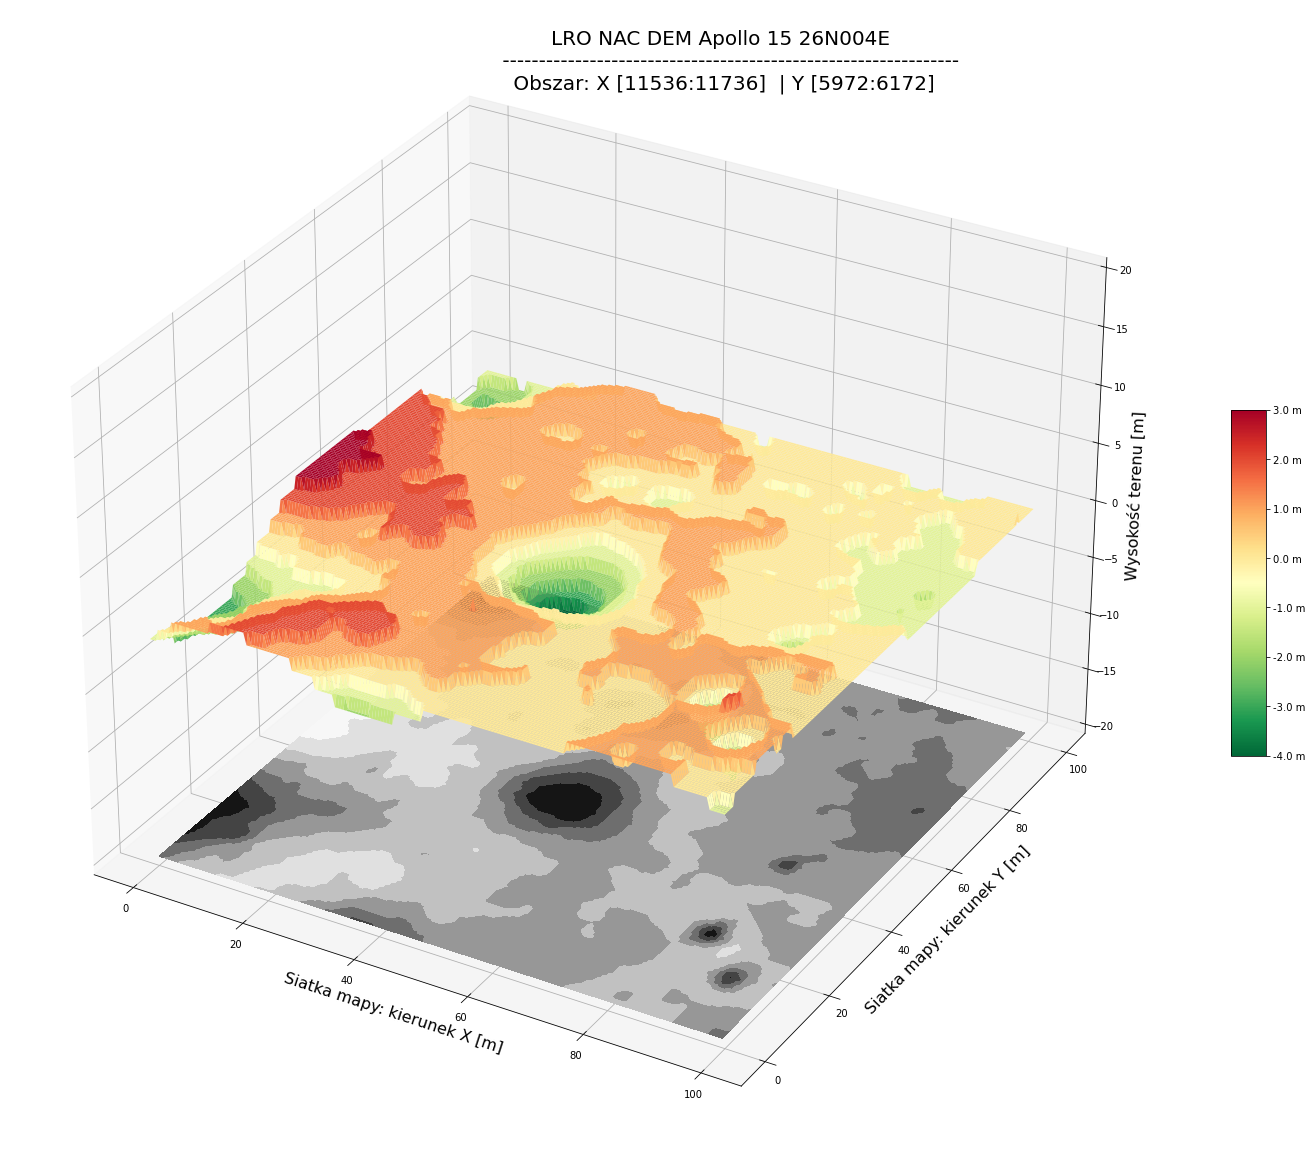

In [232]:
#plot_mesh(img, False)
plot_mesh(img, True, out_path=out_path)

Min slope: 0.0 Median slope: 45.0 Max slope: 63.4375


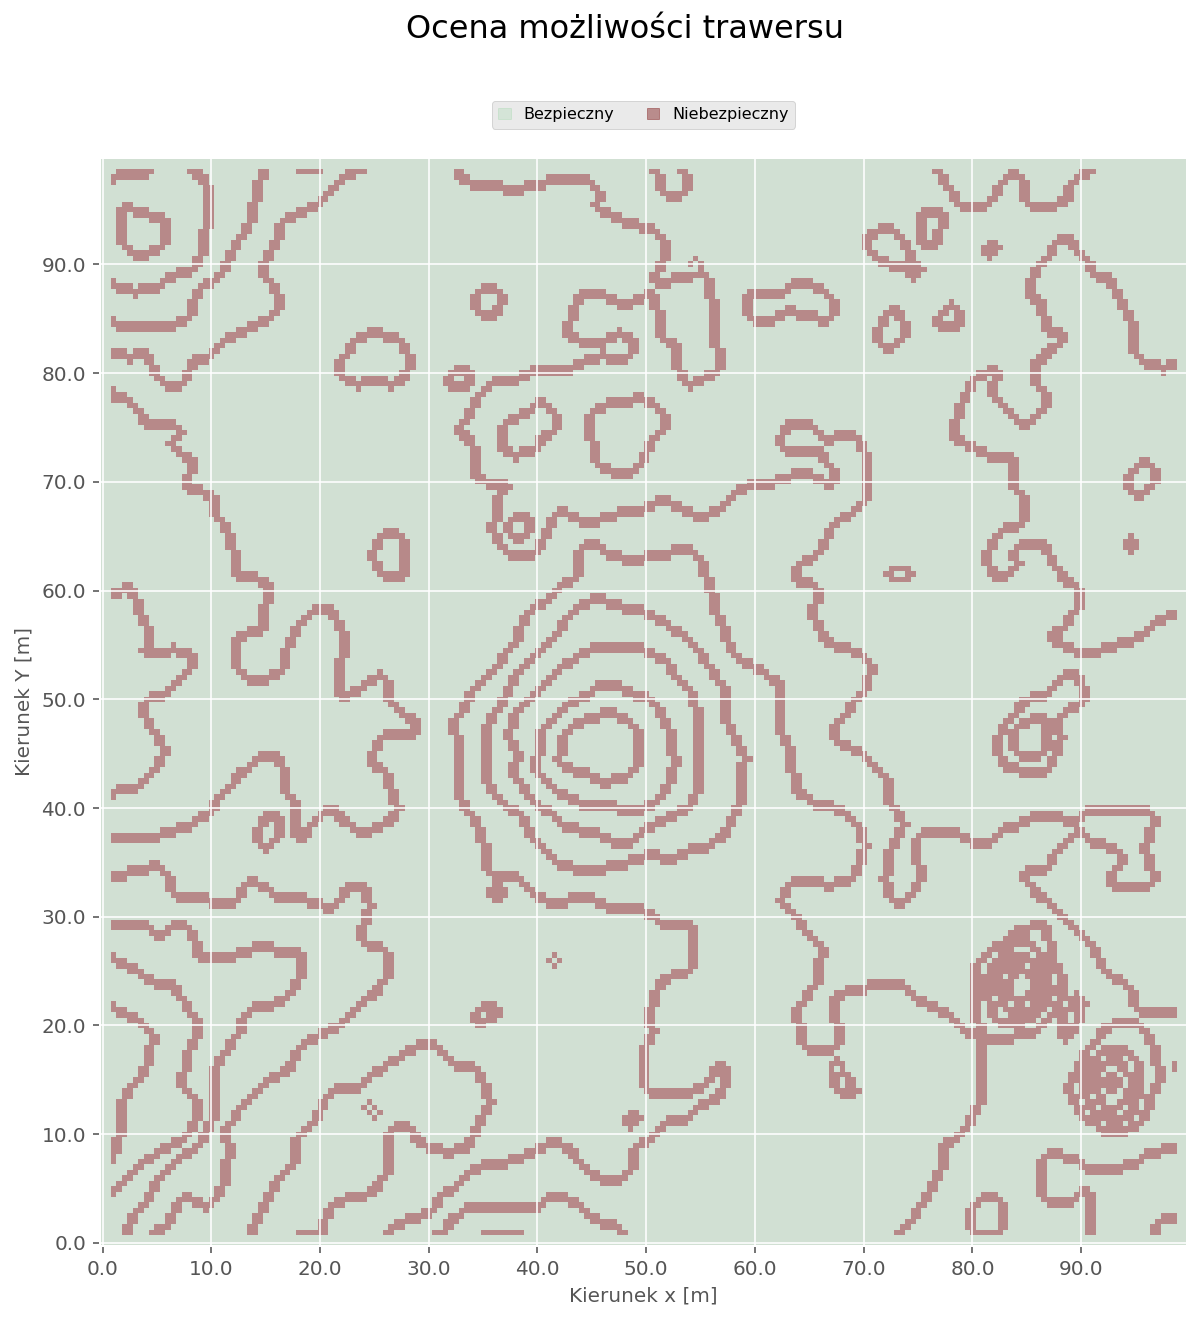

Min slope: 0.0 Median slope: 45.0 Max slope: 63.4375


'../dataset/Small_map\\occupancy_grid.npy'

In [262]:
analyze_slope_map(img, True, out_path=out_path)
img_plot = calculate_slope(img)
save_dem(img_plot, out_path, 'slope.npy')
img_plot = safe_area(img_plot)
save_dem(img_plot, out_path, 'occupancy_grid.npy')

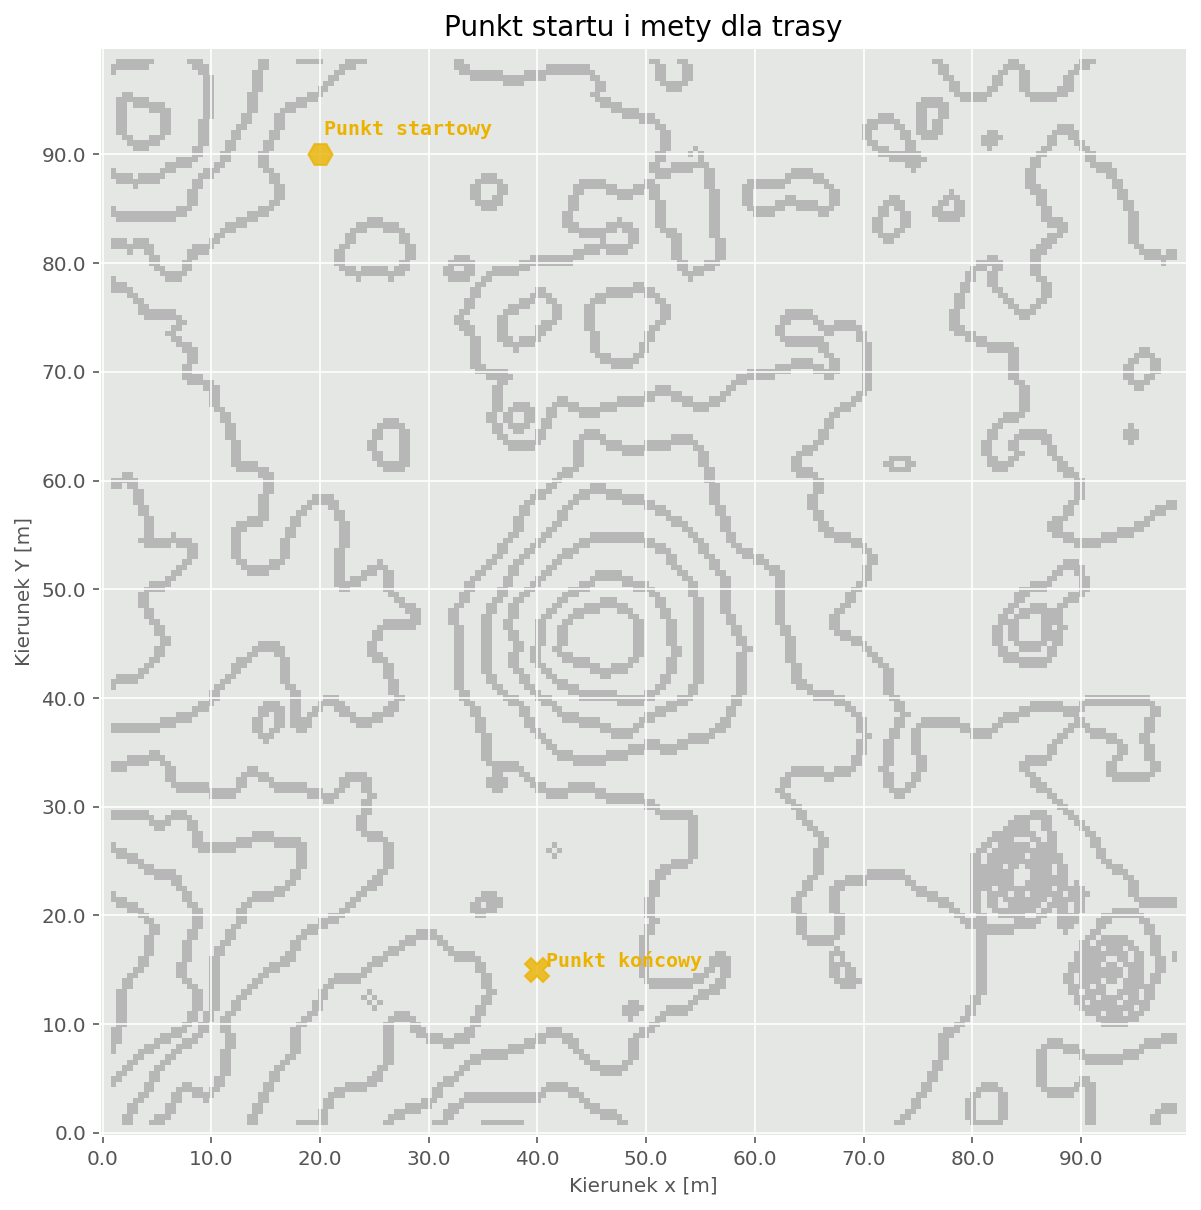

In [251]:
plot_start_end(img_plot,(40,180),(80,30),True,  out_path=out_path)

In [263]:
obstacle_map = img_plot.copy()
obstacle_map[obstacle_map == 0] = False
obstacle_map[obstacle_map != 0] = True
save_dem(obstacle_map, out_path, 'occupancy_grid.npy')

print(obstacle_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [254]:

# set obstacle positions
ox, oy = [], []
for i in range(-10, 60):
    ox.append(i)
    oy.append(-10.0)
for i in range(-10, 60):
    ox.append(60.0)
    oy.append(i)
for i in range(-10, 61):
    ox.append(i)
    oy.append(60.0)
for i in range(-10, 61):
    ox.append(-10.0)
    oy.append(i)
for i in range(-10, 40):
    ox.append(20.0)
    oy.append(i)
for i in range(0, 40):
    ox.append(40.0)
    oy.append(60.0 - i)
        
def calc_grid_position(index, min_position, resolution):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * resolution + min_position
        return pos
    
def calc_obstacle_map(ox, oy):
    resolution = 1
    rr = 1
    min_x = round(min(ox))
    min_y = round(min(oy))
    max_x = round(max(ox))
    max_y = round(max(oy))
    print("min_x:", min_x)
    print("min_y:", min_y)
    print("max_x:", max_x)
    print("max_y:", max_y)

    x_width = round((max_x - min_x) / resolution)
    y_width = round((max_y - min_y) / resolution)
    print("x_width:", x_width)
    print("y_width:", y_width)

    # obstacle map generation
    obstacle_map = [[False for _ in range(y_width)]
                         for _ in range(x_width)]
    for ix in range(x_width):
        x = calc_grid_position(ix, min_x, resolution)
        for iy in range(y_width):
            y = calc_grid_position(iy, min_y, resolution)
            for iox, ioy in zip(ox, oy):
                d = math.hypot(iox - x, ioy - y)
                if d <= rr:
                    obstacle_map[ix][iy] = True
                    break
    return obstacle_map

In [116]:
obs_map = calc_obstacle_map(ox, oy)

min_x: -10
min_y: -10
max_x: 60
max_y: 60
x_width: 70
y_width: 70


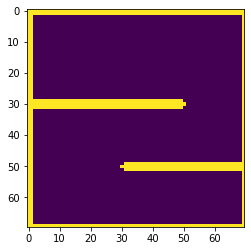

In [118]:
plt.imshow(obs_map)

In [259]:
# Implement Path planning algo

import math

import matplotlib.pyplot as plt

show_animation = False


class AStarPlanner:

    def __init__(self, ox, oy, resolution, rr, obstacle_map= None):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        if obstacle_map is not None:
            self.obstacle_map = obstacle_map
            self.min_x = round(0)
            self.min_y = round(0)
            self.max_x = round(obstacle_map.shape[0]/self.resolution)
            self.max_y = round(obstacle_map.shape[1]/self.resolution)
            self.x_width = round((self.max_x - self.min_x) / self.resolution)
            self.y_width = round((self.max_y - self.min_y) / self.resolution)
        else:
            self.obstacle_map = None
            self.calc_obstacle_map(ox, oy)

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return str(self.x) + "," + str(self.y) + "," + str(
                self.cost) + "," + str(self.parent_index)

    def planning(self, sx, sy, gx, gy):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost + self.calc_heuristic(goal_node,
                                                                     open_set[
                                                                         o]))
            current = open_set[c_id]
            
            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(self.calc_grid_position(current.x, self.min_x),
                         self.calc_grid_position(current.y, self.min_y), "xc")
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect('key_release_event',
                                             lambda event: [exit(
                                                 0) if event.key == 'escape' else None])
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Find goal")
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current
            
            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(current.x + self.motion[i][0],
                                 current.y + self.motion[i][1],
                                 current.cost + self.motion[i][2], c_id)
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node
                  #      print('ID: {} \n Best path set: {}'.format(n_id,open_set[n_id]))

        rx, ry = self.calc_final_path(goal_node, closed_set)

        return rx, ry

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            
            return False
        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))
        print("min_x:", self.min_x)
        print("min_y:", self.min_y)
        print("max_x:", self.max_x)
        print("max_y:", self.max_y)

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)
        print("x_width:", self.x_width)
        print("y_width:", self.y_width)

        # obstacle map generation
        self.obstacle_map = [[False for _ in range(self.y_width)]
                             for _ in range(self.x_width)]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [[1, 0, 1],
                  [0, 1, 1],
                  [-1, 0, 1],
                  [0, -1, 1],
                  [-1, -1, math.sqrt(2)],
                  [-1, 1, math.sqrt(2)],
                  [1, -1, math.sqrt(2)],
                  [1, 1, math.sqrt(2)]]

        return motion


 Start!!
Open set is empty..


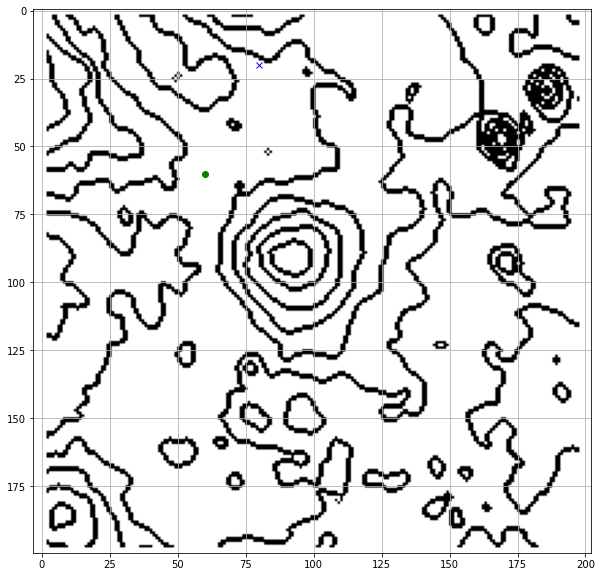

In [260]:
from matplotlib import animation
from IPython.display import HTML

m = obstacle_map

def main():
    print(" Start!!")
    show_animation = True
    # start and goal position
    
    # start and goal position
#     sx = 10.0  # [m]
#     sy = 10.0  # [m]
#     gx = 50.0  # [m]
#     gy = 50.0  # [m]
#     grid_size = 2.0  # [m]
#     robot_radius = 1.0  # [m]

    sx = 60.0  # [m]
    sy = 60.0  # [m]
    gx = 80.0  # [m]
    gy = 20.0  # [m]
    grid_size = 1 # 0.5  # [m]
    robot_radius = 1.0  # [m]

    if show_animation:  # pragma: no cover
        fig, ax = plt.subplots(figsize=(10,10))
       # m=np.rot90(obstacle_map,180)
       # m=np.flip(obstacle_map,axis=0)
        ax.imshow(m, cmap='Greys')
        
        ax.plot(sx, sy, "og")
        ax.plot(gx, gy, "xb")
        ax.grid(True)
        ax.axis("equal")

    a_star = AStarPlanner(ox, oy, grid_size, robot_radius, m)
    rx, ry = a_star.planning(sx, sy, gx, gy)

    if show_animation:  # pragma: no cover
     #   ax.set_xlim(-30,70)
    #    ax.set_ylim(-20,70)
        plt.plot(rx, ry, "-r")
        plt.pause(0.001)
        plt.show()

        
main()

In [77]:
# Implemennt efficency analysis funcs

In [78]:
# Implement plotting gathered data 